# Measuring size of objects in an image
https://www.pyimagesearch.com/2016/03/28/measuring-size-of-objects-in-an-image-with-opencv/

In [1]:
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 10, 20

## Configuration

In [2]:
image_path = "images/example_01.png"
width = 0.997  # Width of the left-most object in the image used for calibration (in inches)

## Auxiliary functions

In [3]:
def midpoint(ptA, ptB):
    """
    Midpoint between two points.
    """
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

## Preprocessing

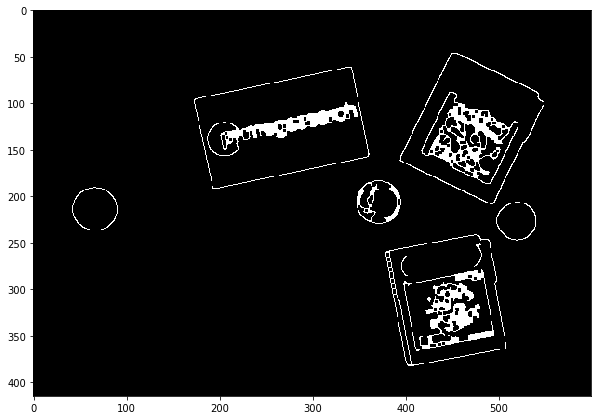

In [4]:
# Load the image, convert it to grayscale, and blur it slightly
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)

# Perform edge detection, then perform a dilation + erosion to close gaps in between object edges
edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

plt.imshow(edged, cmap="gray")

## Image analysis

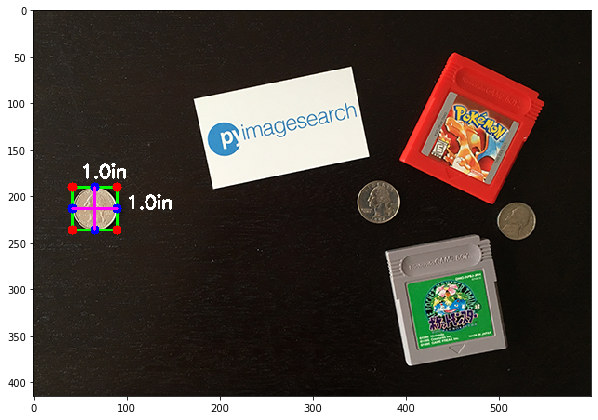

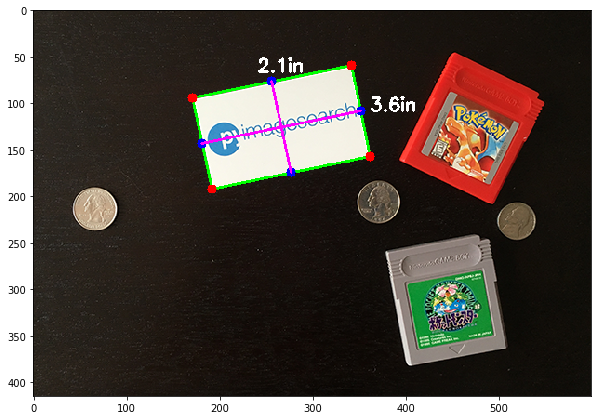

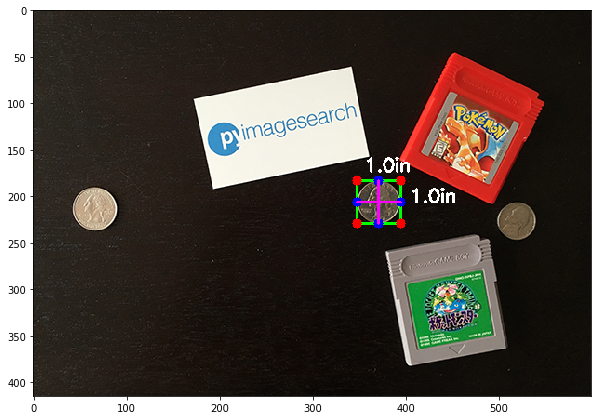

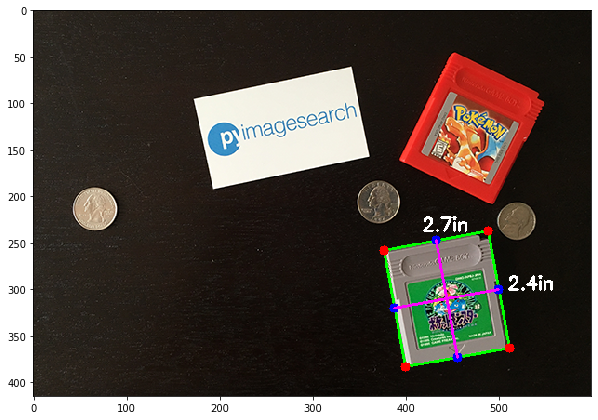

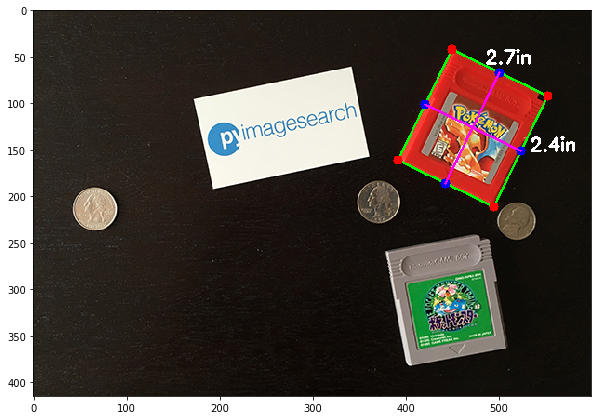

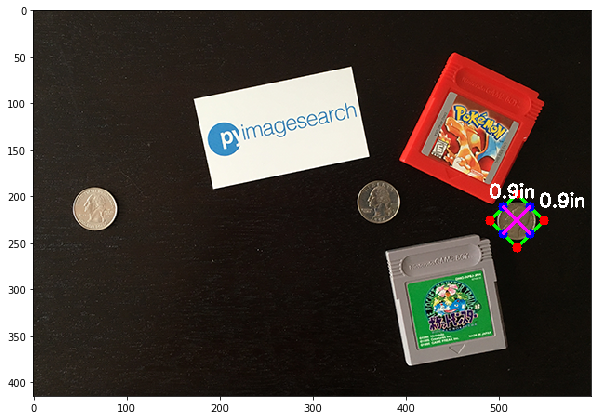

In [5]:
# Find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# Sort the contours from left-to-right and initialize the 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts)
pixelsPerMetric = None

# Loop over the contours individually
for c in cnts:
    # If the contour is not sufficiently large, ignore it
    if cv2.contourArea(c) < 100:
        continue
    
    # Compute the rotated bounding box of the contour
    orig = image.copy()
    box = cv2.minAreaRect(c)
    box = cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    
    # Order the points in the contour such that they appear in top-left, top-right, bottom-right,
    # and bottom-left order, then draw the outline of the rotated bounding box
    box = perspective.order_points(box)
    cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)

    # Loop over the original points and draw them
    for (x, y) in box:
        cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)
        
    # Unpack the ordered bounding box, then compute the midpoint between the top-left and top-right
    # coordinates, followed by the midpoint between bottom-left and bottom-right coordinates
    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)
    
    # Compute the midpoint between the top-left and bottom-left points,
    # followed by the midpoint between the top-right and bottom-right
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)
    
    # Draw the midpoints on the image
    cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
    
    # Draw lines between the midpoints
    cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)), (255, 0, 255), 2)
    cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)), (255, 0, 255), 2)
    
    # Compute the Euclidean distance between the midpoints
    dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
    dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

    # If the pixels per metric has not been initialized, then compute it as the ratio
    # of pixels to supplied metric (in this case, inches)
    if pixelsPerMetric is None:
        pixelsPerMetric = dB / width
        
    # Compute the size of the object
    dimA = dA / pixelsPerMetric
    dimB = dB / pixelsPerMetric
    
    # Draw the object sizes on the image
    cv2.putText(orig, "{:.1f}in".format(dimA), (int(tltrX - 15), int(tltrY - 10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)
    cv2.putText(orig, "{:.1f}in".format(dimB), (int(trbrX + 10), int(trbrY)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)

    # Show the output image
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(orig)